# Unmapping

## Recovering data from scientific images is harder than it sounds

Matt Hall, Scout Team, EDB Lab, Bergen

CC BY-SA

Imagine I want to get the data from this image [CC BY-SA ]

<img src="https://i.stack.imgur.com/dAFPL.png" width=1200; />

Or this one [CC BY-SA Joshua Doubek / pickthis.io]

<img src="https://the-geophysicist.com/wp-content/uploads/2015/03/FlatSpotPickthis1.png" width=1200; />

## The recipe

- <span style="color:lightgray;">Get the data from the figure</span>
- Figure out the colours in the colourmap
- Put the colours in the right order
- Do a reverse look-up from colour to scalar
- <span style="color:lightgray;">Move the data to the right scale</span>

Under some assumptions:

- We know the polarity of the data
- We know the range of the data
- The data are spatial continous

## Start with some data

In [465]:
import scipy.ndimage as snd
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(1111)
raw = rng.random((300, 300))
arr = snd.gaussian_filter(raw, 15)
arr = (arr - arr.min()) / (arr.max() - arr.min())
arr[:5, :5]

array([[0.19770541, 0.1982454 , 0.19934656, 0.20095198, 0.20307213],
       [0.19888639, 0.19942497, 0.20052332, 0.20212445, 0.20423853],
       [0.20128211, 0.20181772, 0.20291015, 0.20450218, 0.20660354],
       [0.20488359, 0.20541459, 0.20649783, 0.20807578, 0.21015748],
       [0.20966076, 0.21018566, 0.21125674, 0.21281609, 0.21487181]])

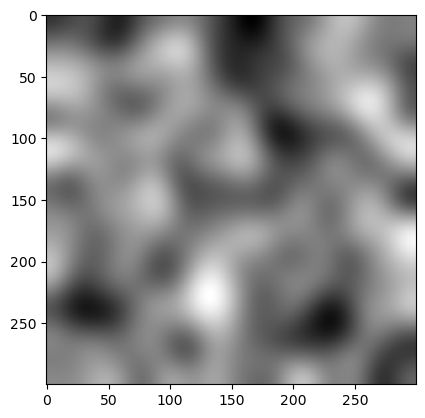

In [466]:
plt.imshow(arr, cmap='gray')


## Let's turn our data into an image

In [467]:
cmap = plt.get_cmap('jet')
rgb = cmap(arr)[..., :3]
rgb[0, :5]

array([[0.        , 0.28431373, 1.        ],
       [0.        , 0.28431373, 1.        ],
       [0.        , 0.3       , 1.        ],
       [0.        , 0.3       , 1.        ],
       [0.        , 0.3       , 1.        ]])

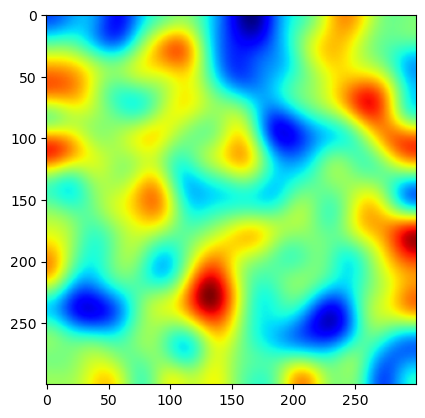

In [468]:
plt.imshow(rgb)

## Plot the pixels in RGB space

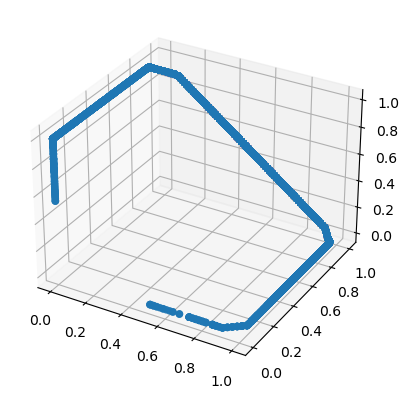

In [469]:
rgb1d = rgb.reshape(-1, 3)[::10]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(*rgb1d.T)

## Recover the original data from this image

In a perfect world, this would be a straightforward lookup.

In [470]:
clut = cmap(np.linspace(0, 1, 256))[..., :3]
clut[:5]

array([[0.        , 0.        , 0.5       ],
       [0.        , 0.        , 0.51782531],
       [0.        , 0.        , 0.53565062],
       [0.        , 0.        , 0.55347594],
       [0.        , 0.        , 0.57130125]])

In [471]:
all(px in clut for px in im1d)

True

## But...

It doesn't work on actual images. **Why?**

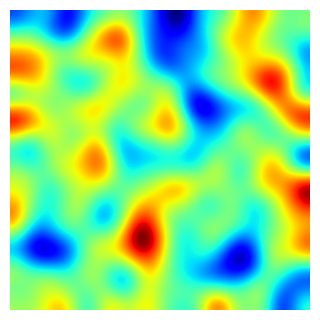

In [472]:
# Set up the figure.
fig = plt.figure(frameon=False)
fig.set_size_inches(3, 3)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

# Plot the data.
ax.imshow(arr, cmap='jet')

# Save the image.
plt.savefig('test.jpg')
plt.savefig('test.png')

In [480]:
from PIL import Image

# Load the image as an array.
img = Image.open('test.jpg')
ima = np.asarray(img)[..., :3] / 255
ima.shape

(300, 300, 3)

In [481]:
all(px in clut for px in ima.reshape(-1, 3))

False

## JPEG colours

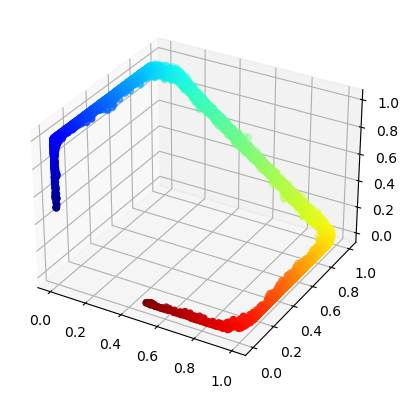

In [482]:
ima1d = ima.reshape(-1, 3)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(*ima1d[::5].T, c=ima1d[::5])

## Nearest-neighbour lookup

In [483]:
from scipy.spatial import cKDTree

kdtree = cKDTree(clut)
dist, ix = kdtree.query(ima)
rec = ix / ix.max()

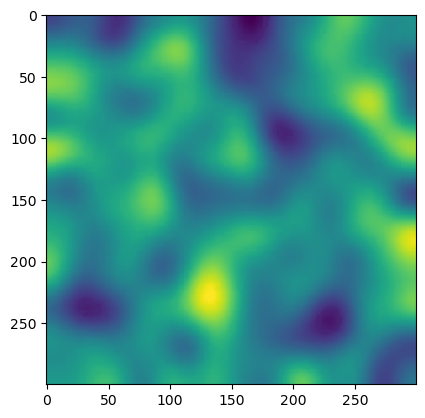

In [484]:
plt.imshow(rec)

## Difference

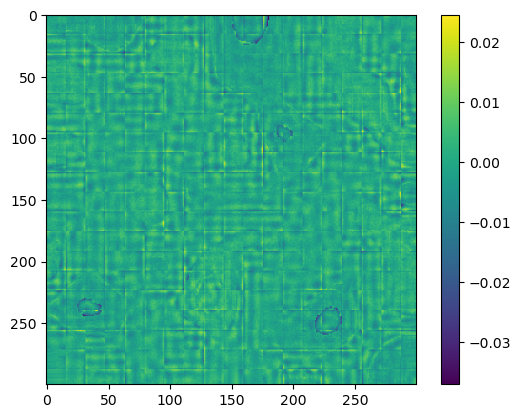

In [485]:
plt.imshow(rec - arr)
plt.colorbar()

## But...

### ...we did all that with knowledge of the colormap

We need a way to sense the CLUT directly from the image.

In [479]:
np.unique(ima1d, axis=0).shape

(253, 3)

### Damn.

## Quanitzation

In practice, we need to **quantize** the image.

In [437]:
from sklearn.cluster import KMeans

clu = KMeans(n_clusters=128)
clu.fit(ima1d[::5])
clu.cluster_centers_[:5]

array([[0.00409822, 0.58177001, 0.99445328],
       [0.65453009, 0.99726166, 0.31446924],
       [0.99417706, 0.69860963, 0.00693999],
       [0.29838965, 0.99766375, 0.66760117],
       [0.92238942, 0.99293206, 0.04762882]])

In [438]:
centroids = np.clip(clu.cluster_centers_, 0, 1)

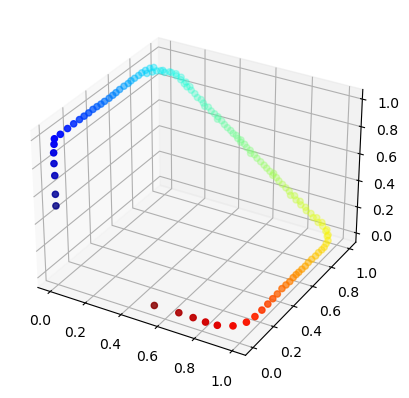

In [439]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(*centroids.T, c=centroids)

## The quantized image

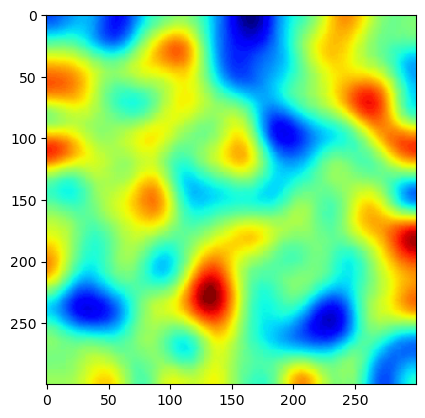

In [440]:
idx = clu.predict(ima1d).reshape(300, 300)
qnt = centroids[idx]

plt.imshow(qnt)

## Build a transition matrix

In [441]:
from skimage.feature import graycomatrix

glcm = graycomatrix(idx,
                    distances=[1],
                    angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                    levels=256,
                    symmetric=True
                    )

glcm = np.sum(np.squeeze(glcm), axis=-1)

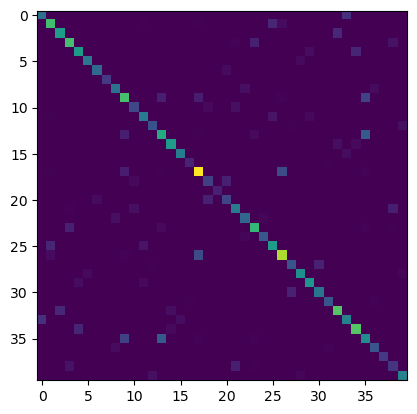

In [442]:
plt.imshow(glcm[:40, :40])

## The ordering problem

Create a graph, prune it, find the longest shortest path (the diametral path).

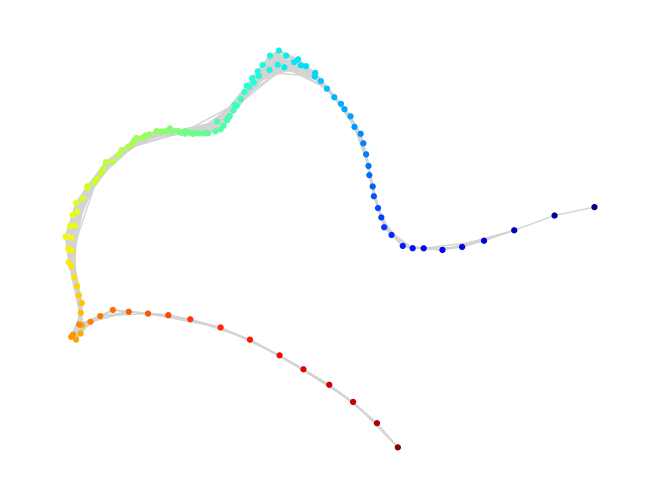

In [443]:
import networkx as nx

G = nx.from_numpy_array(glcm)
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len)
H = G.subgraph(Gcc[-1])

color = [centroids[n] for n in H]
layout = nx.spring_layout(H)
nx.draw(H, layout, node_size=12, node_color=color, edge_color='lightgray')

### Pruning

- Remove edges between vertices that have few transitions
- Remove edges between vertices that are distant in colour space
- Remove vertices with a large number of different neighbours
- Remove disconnected vertices.

Now find the longest shortest path between all connected vertices. This is the colourmap.

## Using `unmap`

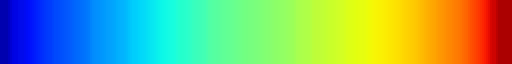

In [444]:
import unmap

cmap = unmap.guess_cmap_from_array(ima, equilibrate=True)

cmap

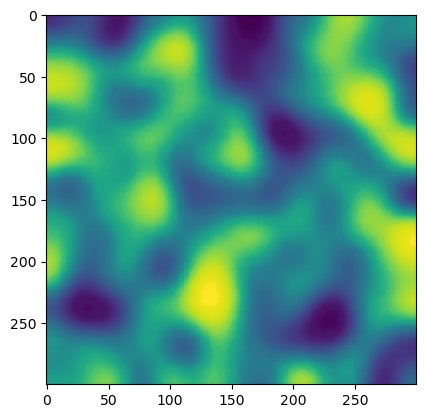

In [445]:
rec = unmap.unmap(ima, cmap, threshold=0.5)

plt.imshow(rec)

## Difference

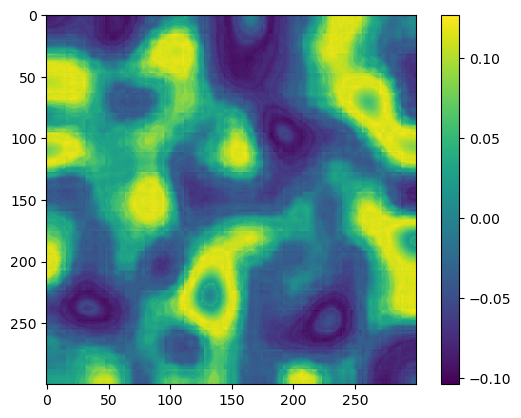

In [446]:
plt.imshow(rec - arr)
plt.colorbar()

## With a PNG

JPEG is really bad, it does much better with a PNG.

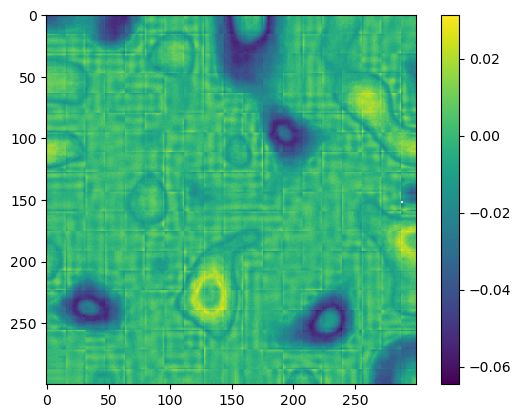

In [447]:
cmap = unmap.guess_cmap_from_image('test.png')

rec = unmap.unmap(ima, cmap)

plt.imshow(rec - arr)
plt.colorbar()

## Conclusion

- 80% of the time, it works every time
- It's really only an ordering problem
- There is some ML work to achieve this result
- What does a useful implementation look like?